In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [324]:
import os
import pickle
import operator
import itertools
import tskit
import msprime
import numpy as np
import pyslim
import tqdm
import scipy.stats as stats
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib as mpl

import jax.numpy as jnp

from bgspy.models import BGSModel 
from bgspy.genome import Genome
from bgspy.data import GenomeData

In [4]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['mathtext.fontset'] = 'cm'
plt.style.use('./buffalo.mplstyle')

## Load B Maps

In [5]:
pkl_b_file = '../data/bmaps/bgspy/bmap_hg38_6x7grid_10000step_chr10.pkl'
m = BGSModel.load(pkl_b_file)
g = m.genome

In [6]:
bp = m.BpScores
b = m.BScores

## Likelihood Experiments

In [343]:
#ts = tskit.load('../data/chrombgs_chr10_thresh0_N1000_mu1e-09_sh0.0316_chr10_seed1004092737_rep76_treeseq.tree')
ts = tskit.load('../data/chrombgs_chr10_thresh0_N1000_mu1e-08_sh0.01_chr10_seed1006500984_rep67_treeseq.tree')
ts = ts.delete_sites([m.site for m in ts.mutations()])

In [344]:
ts = msprime.sim_mutations(ts, rate=1e-7, discrete_genome=True, model=msprime.BinaryMutationModel())

In [345]:
gd = GenomeData(g)
gd.load_counts_from_ts(ts=ts, chrom='chr10')

In [346]:
gd.counts

{'chr10': array([[2000.,    0.],
        [2000.,    0.],
        [2000.,    0.],
        ...,
        [2000.,    0.],
        [2000.,    0.],
        [2000.,    0.]])}

In [347]:
plt.plot(*gd.bin_pi(1e6)[1]['chr10'].pairs) 
N = 1000
mu = 1e-7
plt.axhline(4*N*mu, c='0.22', linestyle='dashed')

AttributeError: 'BinnedStat' object has no attribute 'sum'

In [ ]:
Bp = m.BpScores.bin_means(bins)
Bp._build_w_interpolators(jax=True)



In [104]:
ww = np.array([1e-9])
#Bp._w_interpolators['chr10'](ww)

In [68]:
x = np.linspace(Bp.w.min(), Bp.w.max(), 50)
Bp._w_interpolators['chr10'][20][5][0](x)

nx = 82
nt = 1

plt.plot(Bp.w, Bp.B['chr10'][nx, :, nt, 0])
plt.plot(x, Bp._w_interpolators['chr10'][nx][nt][0](x))
deg = 1
y = Bp._w_interpolators['chr10'][nx][nt][0](x)
y = Bp.B['chr10'][nx, :, nt, 0]
plt.semilogx()

TypeError: 'function' object is not subscriptable

In [348]:
def negloglik_maker(Y, logB, ww):
    """
    Returns negative log-likelihood for a π0 and a 
    matrix W (nt x nf).
    
    
    """
    nS = Y[:, 0][:, None, None]
    nD = Y[:, 1][:, None, None]
    
    nx, nw, nt, nf = logB.shape
    
    def negll(theta):
        pi0, w = theta[0], theta[1:]
        w = w.reshape((nt, nf))
        assert w.shape == (nt, nf)
        ll = jnp.zeros((nx, nt, nf), dtype=float)
        # interpolate B(w)'s
        logBw = jnp.zeros((nx, nt, nf), dtype=float)
        for i in range(nx):
            for j in range(nt):
                for k in range(nf):
                    logBw.at[i, j, k].set(jnp.interp(w[j, k], ww, logB[i, :, j, k]))
        pibar = pi0 * jnp.exp(logBw)
        llm = nD * jnp.log(pibar) + nS * jnp.log(1-pibar)
        return -jnp.einsum('ijk->i', llm).sum()
        
    return negll

def theta_init(w, nt, nf, logpi0_min=-4, logpi0_max=-2):
    n = int(nt * nf + 1)
    theta = np.empty(n, dtype=float)
    W = np.exp(np.random.uniform(np.log(w.min()), np.log(w.max()), n-1))
    pi0 = np.exp(np.random.uniform(logpi0_min, logpi0_max, 1))
    theta[0] = pi0
    theta[1:] = W.flatten()
    low = np.empty(n, dtype=float)
    high = np.empty(n, dtype=float)
    low[0] = 10**logpi0_min
    high[0] = 10**logpi0_max
    low[1:] = w.min()
    high[1:] = w.max()
    return theta, (low, high)
    
    

In [349]:
def negloglik_maker2(Y, logB, ww):
    """
    Returns negative log-likelihood for a π0 and a 
    matrix W (nt x nf).
    
    
    """
    nS = Y[:, 0][:, None, None]
    nD = Y[:, 1][:, None, None]
    
    nx, nw, nt, nf = logB.shape
    
    def negll(theta):
        pi0, w = theta[0], theta[1:]
        w = w.reshape((nt, nf))
        assert w.shape == (nt, nf)
        ll = np.zeros((nx, nt, nf), dtype=float)
        # interpolate B(w)'s
        logBw = np.zeros((nx, nt, nf), dtype=float)
        for i in range(nx):
            for j in range(nt):
                for k in range(nf):
                    logBw[i, j, k] = np.interp(w[j, k], ww, logB[i, :, j, k])
        pibar = pi0 * np.exp(np.einsum('ijk->i', logBw))
        llm = nD * np.log(pibar) + nS * np.log(1-pibar)
        return -llm.sum()
        
    return negll

In [350]:
nll2 = negloglik_maker2(Y, B, m.w)

In [351]:
nll2(theta_init(m.w, m.t.size, 1)[0])

1730746557997748.5

In [352]:
theta_init(m.w, m.t.size, 1)

(array([3.47948303e-02, 3.66075023e-10, 2.72438687e-08, 6.27895570e-10,
        1.04053688e-10, 1.98578059e-10, 1.02752385e-08, 5.39729147e-10]),
 (array([1.e-04, 1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10]),
  array([1.00000000e-02, 3.16227766e-08, 3.16227766e-08, 3.16227766e-08,
         3.16227766e-08, 3.16227766e-08, 3.16227766e-08, 3.16227766e-08])))

In [ ]:
res = []
for i in tqdm.tqdm(range(50)):
    start, bounds = theta_init(m.w, m.t.size, 1)
    res.append(minimize(nll2, start, bounds=Bounds(*bounds), options={'disp': False}).x)

 16%|█████████████████████████████████████▊                                                                                                                                                                                                      | 8/50 [00:07<00:38,  1.09it/s]

In [337]:
res = np.stack(res)

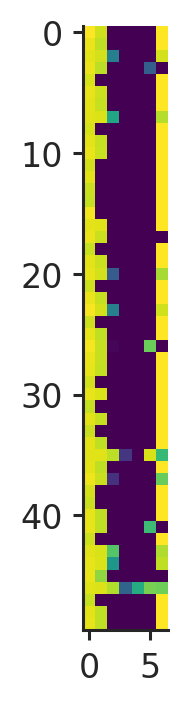

In [342]:
plt.imshow(res[:, 1:])

[]

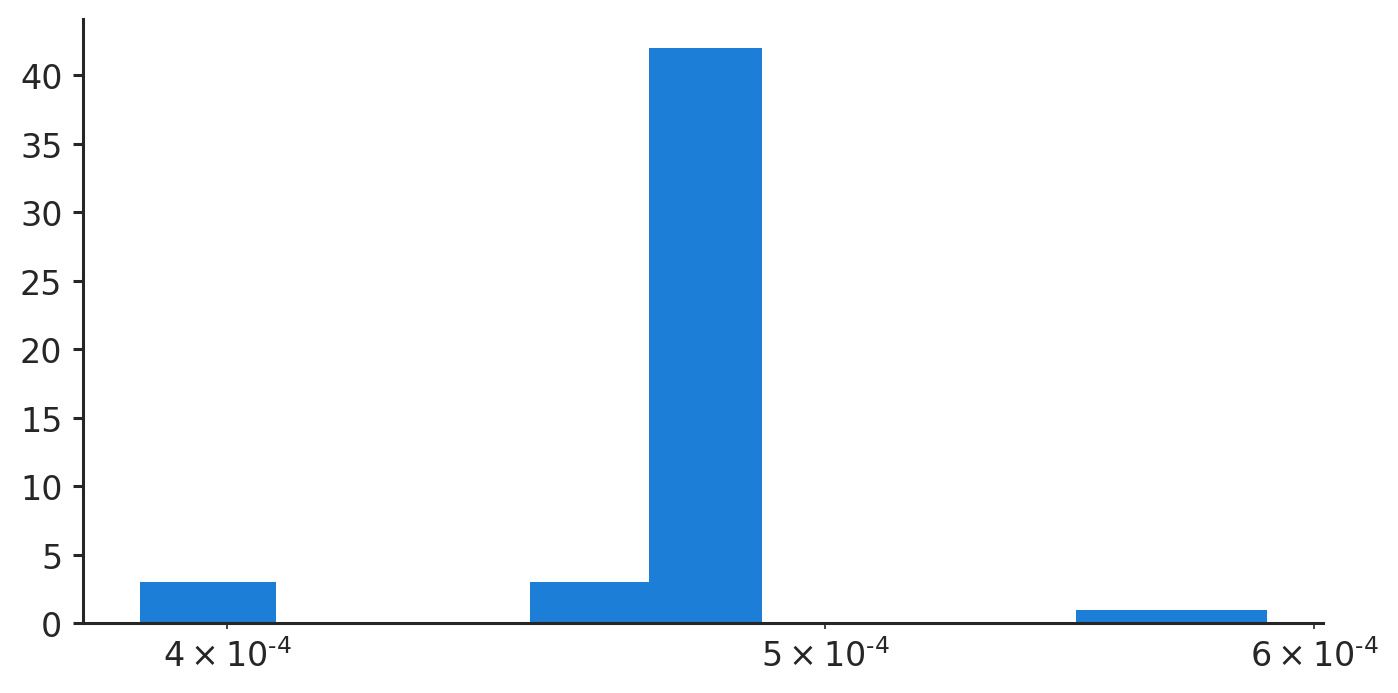

In [341]:
plt.hist(res[:, 0])
plt.semilogx()

[]

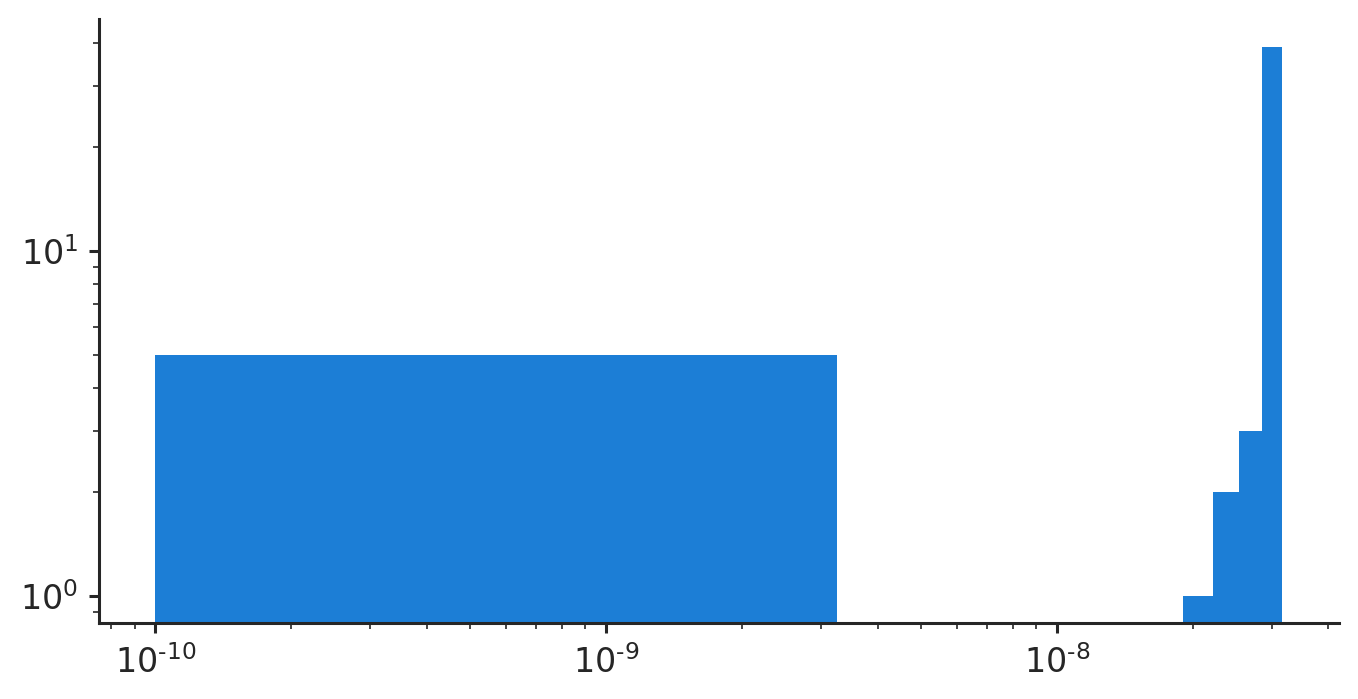

In [336]:
plt.hist(np.stack(res)[:, 7])
plt.loglog()

In [259]:
from jax import grad, hessian, jacobian
from scipy.optimize import Bounds

In [260]:
nll = negloglik_maker(Y, B, m.w)

In [261]:
from scipy.optimize import minimize
jacobian_  = jacobian(nll)
hessian_ = hessian(nll)

In [262]:
start.shape

(8,)

In [220]:
thetas = [np.array([pi0, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8]) for pi0 in np.logspace(-5, -1, 40)]

In [222]:
lls = [nll(theta) for theta in thetas]

0.0003455107294592218


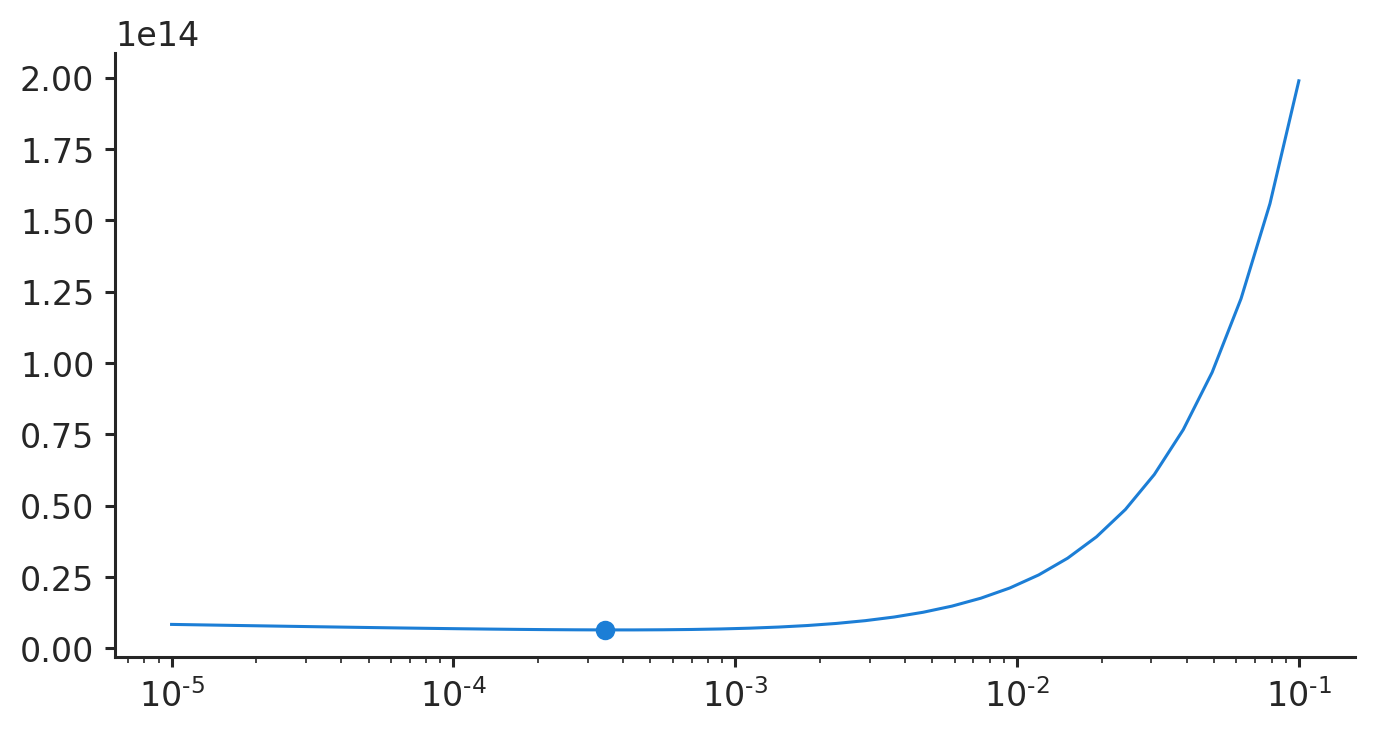

In [229]:
pi0s = np.logspace(-5, -1, 40)
plt.plot(pi0s, lls)
plt.scatter(pi0s[np.argmin(lls)], lls[np.argmin(lls)])
plt.semilogx()
print(pi0s[np.argmin(lls)])

In [303]:
start, bounds = theta_init(m.w, m.t.size, 1)
minimize(nll, start, options={'disp': True}, jac = jacobian_)

KeyboardInterrupt: 

In [205]:
start

array([2.04454879e-02, 7.33631114e-09, 2.10422537e-08, 6.64299202e-09,
       9.01069498e-09, 1.39996536e-10, 3.96813345e-09, 1.70211765e-10])

In [202]:
start, bounds = theta_init(m.w, m.t.size, 1)
minimize(nll, start, method='Newton-CG', options={'disp': True}, jac = jacobian_,  hess=hessian_)

         Current function value: 383328783958016.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
         Hessian evaluations: 1


     fun: 383328783958016.0
     jac: None
 message: "Warning: CG iterations didn't converge. The Hessian is not positive definite."
    nfev: 1
    nhev: 1
     nit: 0
    njev: 1
  status: 3
 success: False
       x: array([1.84677961e-01, 1.51273749e-10, 1.90351835e-09, 6.93508809e-10,
       1.20922429e-08, 1.37536392e-10, 1.05325234e-08, 8.86809434e-09])

In [203]:
start.shape

(8,)

In [198]:
start

array([2.60776882e-01, 3.26798047e-09, 1.14608302e-10, 1.14881876e-09,
       6.80209360e-09, 1.24738907e-09, 5.72174968e-10, 4.48510251e-09])

In [54]:
Bp._build_w_interpolators(jax=True)

Bp._w_interpolators['chr10'][nx][nt][0](x)

array([-1.41978785e-06, -1.05535936e-05, -1.96873993e-05, -2.88212053e-05,
       -3.79550114e-05, -4.70888170e-05, -5.62226209e-05, -6.53564248e-05,
       -7.44902287e-05, -8.36240326e-05, -9.27578365e-05, -1.01891640e-04,
       -1.11025444e-04, -1.20159248e-04, -1.29293052e-04, -1.38426856e-04,
       -1.47560663e-04, -1.56694473e-04, -1.65828283e-04, -1.74962092e-04,
       -1.84095902e-04, -1.93229712e-04, -2.02363521e-04, -2.11497331e-04,
       -2.20631141e-04, -2.29764950e-04, -2.38898760e-04, -2.48032569e-04,
       -2.57166379e-04, -2.66300189e-04, -2.75433998e-04, -2.84567808e-04,
       -2.93701618e-04, -3.02835427e-04, -3.11969237e-04, -3.21103047e-04,
       -3.30236856e-04, -3.39370666e-04, -3.48504475e-04, -3.57638285e-04,
       -3.66772095e-04, -3.75905904e-04, -3.85039714e-04, -3.94173524e-04,
       -4.03307333e-04, -4.12441143e-04, -4.21574953e-04, -4.30708762e-04,
       -4.39842572e-04, -4.48976381e-04])

In [49]:
Bp.B['chr10'][nx, :, nt, 0]

array([-1.41978785e-06, -4.48976334e-06, -1.41978762e-05, -4.48976280e-05,
       -1.41978744e-04, -4.48976381e-04])

In [107]:
B = Bp.B['chr10']

In [12]:
from itertools import product

def loglik(pi0, B, Y):
    pibar = pi0 * np.exp(B)
    nS = Y[:, 0][:, None, None, None]
    nD = Y[:, 1][:, None, None, None]
    ll = nD * np.log(pibar) + nS * np.log(1-pibar)
    lls = ll.sum(axis=0)
    nw, nt = B.shape[1], B.shape[2]
    wi, ti = np.arange(nw), np.arange(nt)
    nf = B.shape[3]
    wt = list(product(wi, ti))
    xi = list(product(*[wt for _ in range(nf)]))
    comb_lls = np.zeros(len(xi))
    for i, row in enumerate(xi):
        for j, pair in enumerate(row):
            comb_lls[i] += lls[pair[0], pair[1], j]
    return comb_lls, xi


def pred(pi0, B, ml_xi):
    Bc = np.array([B[:, wi, ti, i] for i, (wi, ti) in enumerate(ml_xi)])
    pibar = pi0 * np.exp(Bc.sum(axis=0))
    return pibar

In [13]:
# bin the genome data counts and do data reduction
bins, y = gd.bin_reduce(1e6)

# get the data out of the binnedstat (contains n too)
# note off-by-one
Y = y['chr10'].stat[1:, :]

In [41]:
# bin the Bs at the same level, using same bins
B = m.BScores.bin_means(bins, return_bins=True)['chr10'].stat

[]

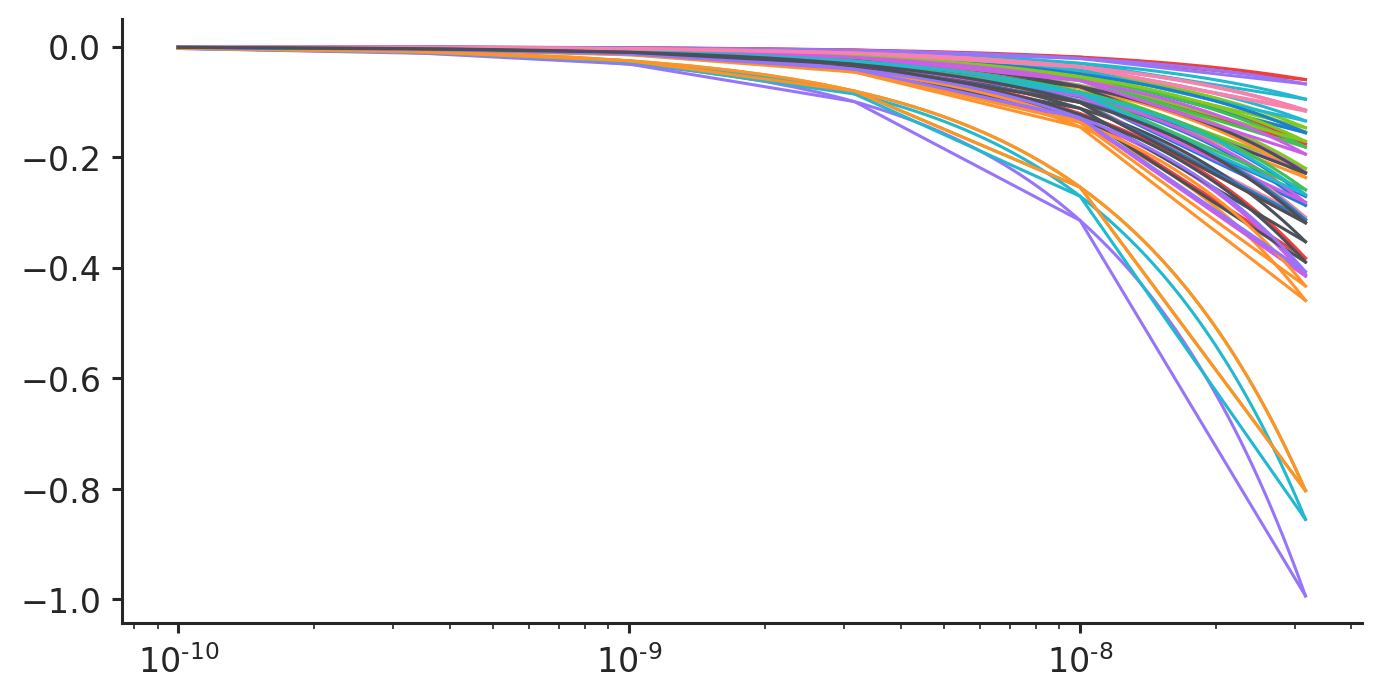

In [89]:
for i in np.random.randint(0, B.shape[0], 40):
    x = np.linspace(m.w.min(), m.w.max(), 100)
    lines = plt.plot(x, interp1d(m.w, B[i, :, 4, 0])(x))
    plt.plot(m.w, B[i, :, 4, 0], c=lines[0].get_color())
plt.semilogx()

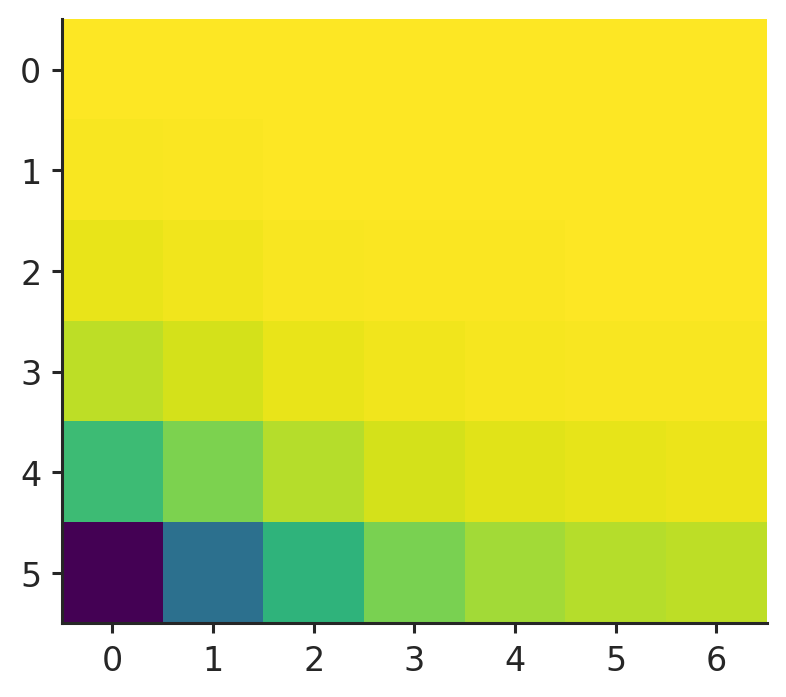

In [67]:
plt.imshow(B[110, :, :, 0])

In [42]:
Y.shape, B.shape

((134, 2), (134, 6, 7, 1))

In [43]:
pi0s = np.logspace(-5, -1, 10)
lls = [np.max(loglik(pi0, B, Y)[0]) for pi0 in pi0s]

0.0005994842503189409


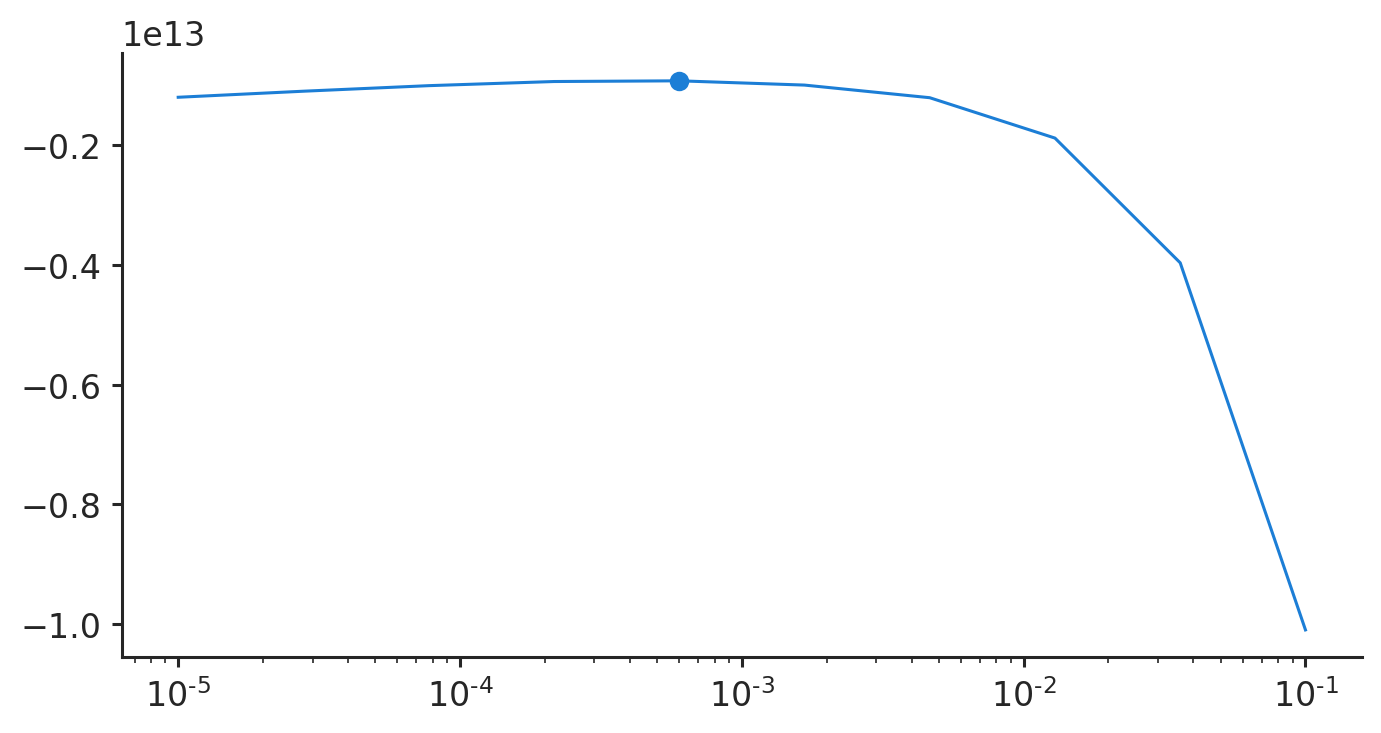

In [44]:
plt.plot(pi0s, lls)
plt.semilogx()
plt.scatter(pi0s[np.argmax(lls)], np.max(lls))
#plt.axvline(gwpi, c='r')

mle_pi0 = pi0s[np.argmax(lls)]
print(mle_pi0)

In [63]:
loglik_interpol(mle_pi0, B, Y, m.w)(1e-3, 

/tmp/ipykernel_73935/3819483232.py:35: DeprecationWarning: Please use `interp1d` from the `scipy.interpolate` namespace, the `scipy.interpolate.interpolate` namespace is deprecated.
  interpols[i][j] = interpolate.interp1d(w, y, kind='quadratic', bounds_error=False, fill_value=-np.Inf)


<function __main__.loglik_interpol.<locals>.ll_func(x)>

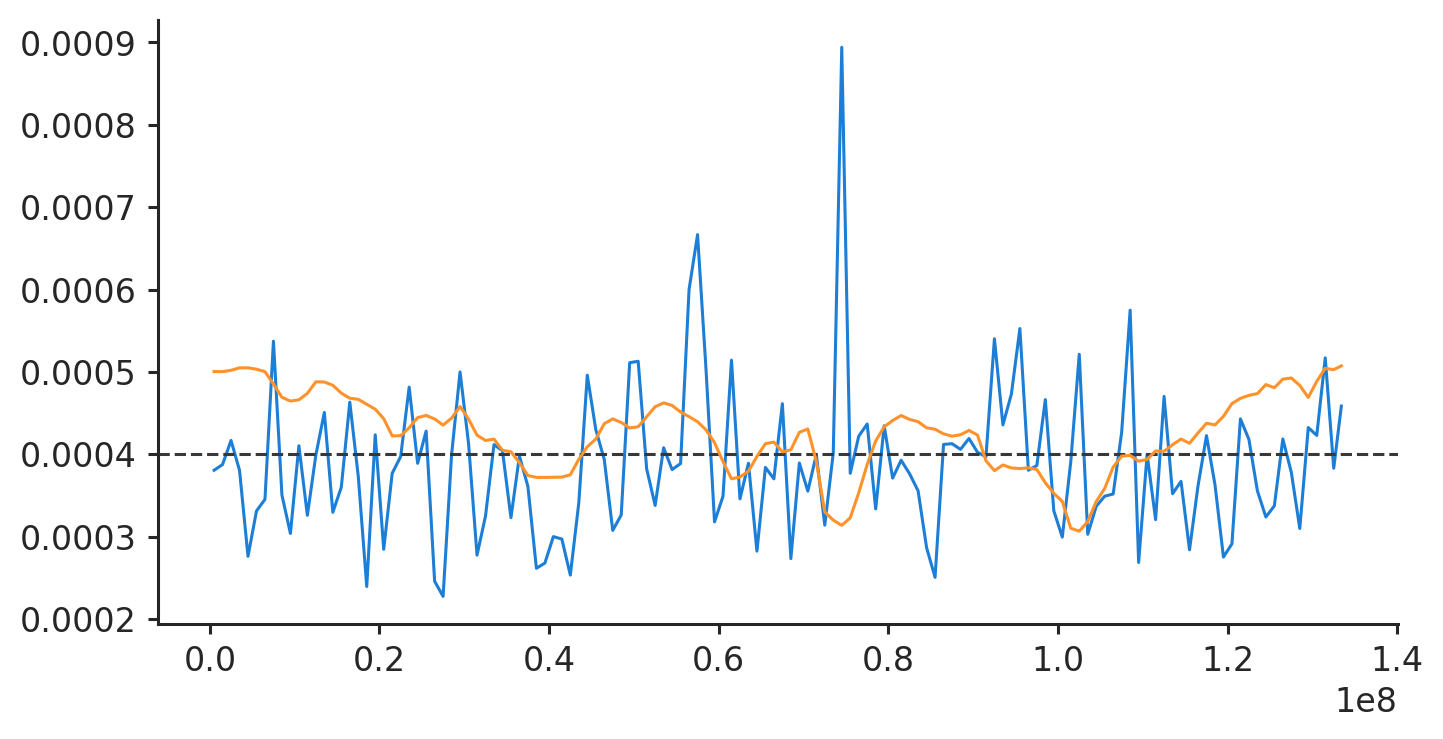

In [57]:
plt.plot(*gd.bin_pi(1e6)[1]['chr10'].pairs) 
N = 1000
mu = 1e-7
plt.axhline(4*N*mu, c='0.22', linestyle='dashed')
plt.plot(bins.midpoints['chr10'], pred(mle_pi0, B, grid[np.argmax(ll)]))

In [121]:
Bp = m.BpScores.bin_means(bins)

In [123]:
Bp._build_w_interpolators()

In [124]:
len(Bp._w_interpolators['chr10'])

134

In [156]:
np.poly1d(np.polyfit(x, Bp._w_interpolators['chr10'][20][5][0](x), 1))

poly1d([-6.22005220e+06,  3.93540157e-09])

[]

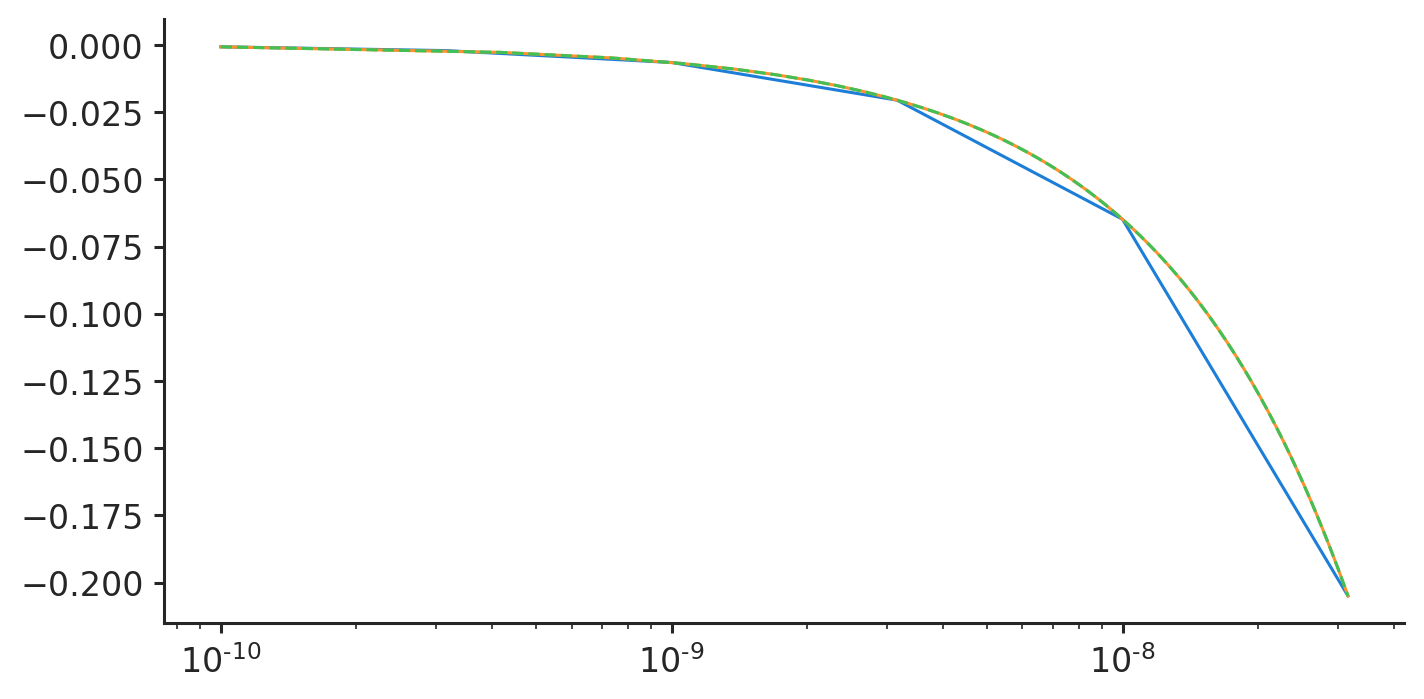

In [173]:
nx = 83
nt = 5

plt.plot(Bp.w, Bp.B['chr10'][nx, :, nt, 0])
plt.plot(x, Bp._w_interpolators['chr10'][nx][nt][0](x))
deg = 1
y = Bp._w_interpolators['chr10'][nx][nt][0](x)
y = Bp.B['chr10'][nx, :, nt, 0]
f = np.poly1d(np.polyfit(m.w, y, deg))
plt.plot(x, f(x), linestyle='dashed')
plt.semilogx()

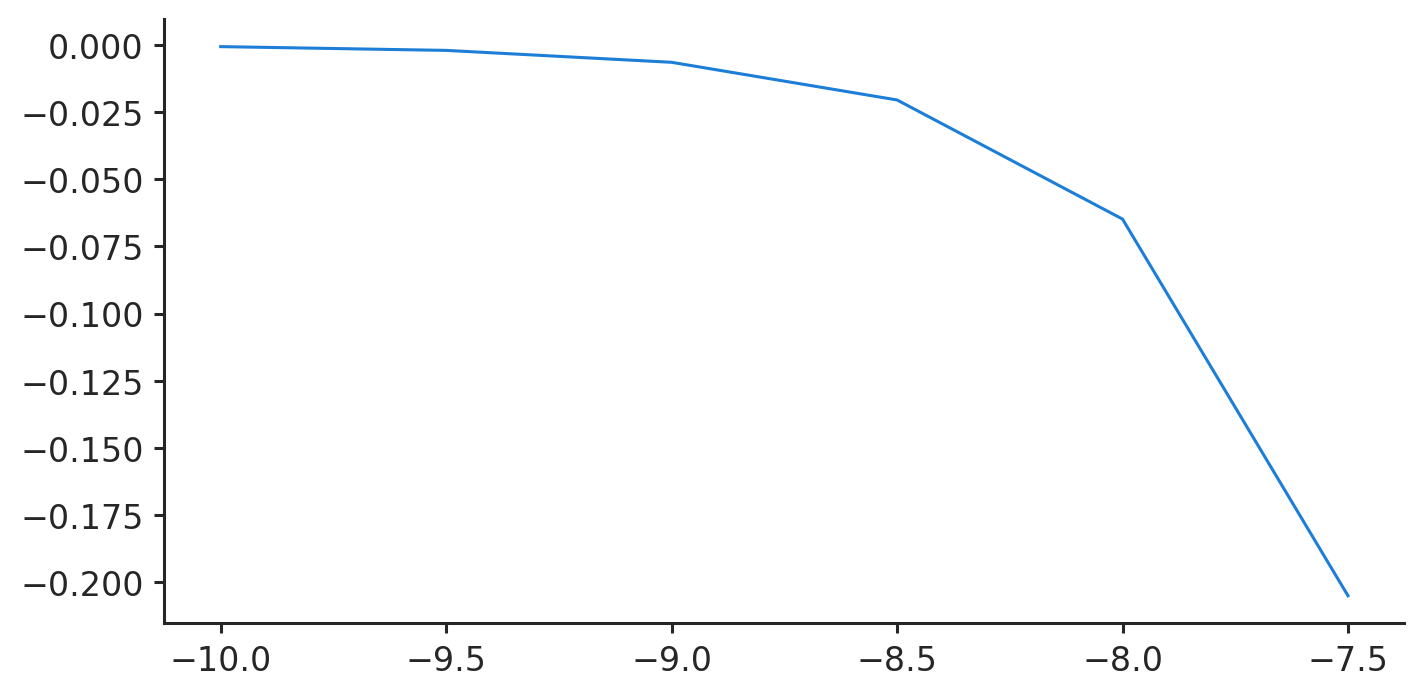

In [185]:
plt.plot(np.log10(m.w), y)
#plt.axline((m.w[0], y[0]), slope=(y[-1] - y[0]) / (m.w[-1] - m.w[0]))

In [189]:
import jax.numpy as jnp

ImportError: /home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/jaxlib/xla_extension.so)

In [182]:
m.w, y
(y[-1] - y[0]) / (m.w[-1] - m.w[0])

-6481876.561590047

In [186]:
m.w, y

(array([1.00000000e-10, 3.16227766e-10, 1.00000000e-09, 3.16227766e-09,
        1.00000000e-08, 3.16227766e-08]),
 array([-0.00064819, -0.00204975, -0.00648188, -0.02049749, -0.06481875,
        -0.20497493]))

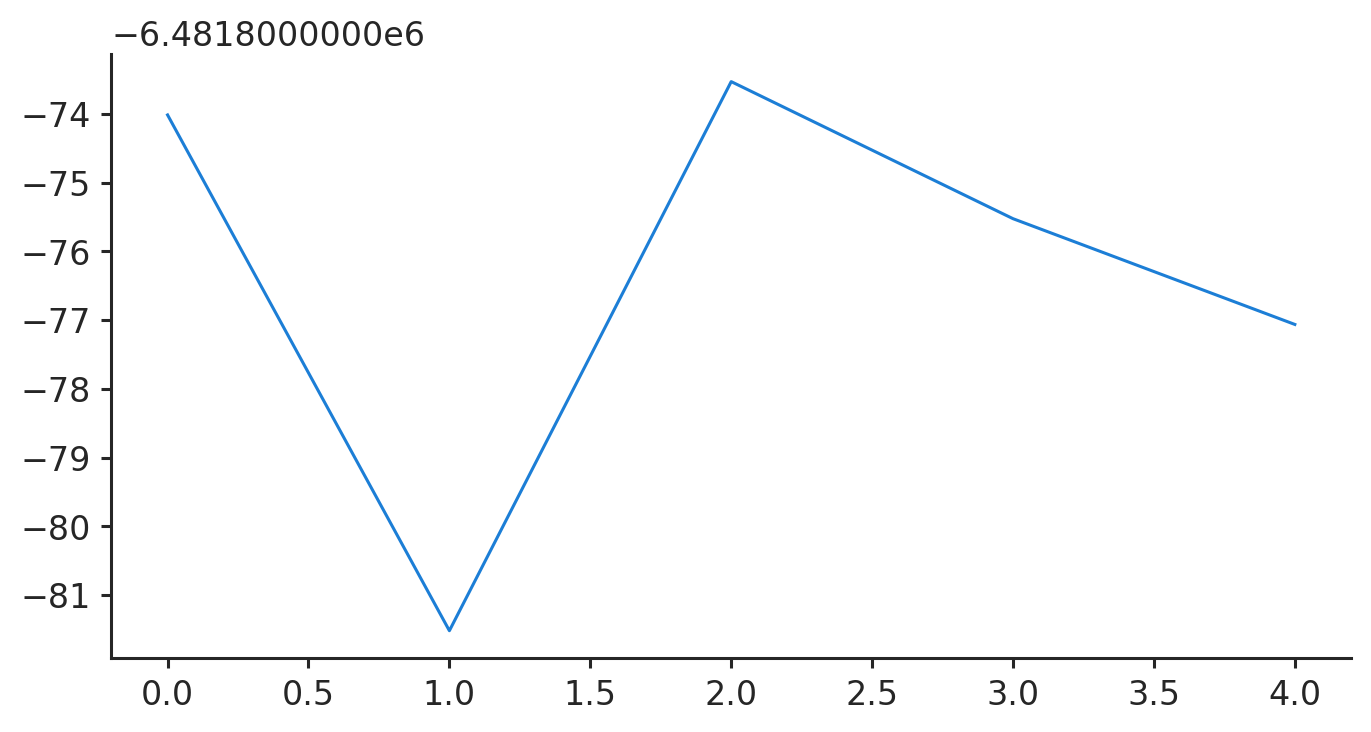

In [188]:

plt.plot(np.diff(y) / np.diff(m.w))

In [150]:
#Bp.B_w_interpolated(1e-8, 'chr10')

In [ ]:
def loglik_interpolB(pi0, Bchrom, Y):
    nS = Y[:, 0][:, None, None, None]
    nD = Y[:, 1][:, None, None, None]
    
    def ll(pi0, w):
        b = B.B_w_interpolated
    
    pibar = pi0 * np.exp(B)
    ll = nD * np.log(pibar) + nS * np.log(1-pibar)
    lls = ll.sum(axis=0)
    nw, nt = B.shape[1], B.shape[2]
    wi, ti = np.arange(nw), np.arange(nt)
    nf = B.shape[3]
    wt = list(product(wi, ti))
    xi = list(product(*[wt for _ in range(nf)]))
    comb_lls = np.zeros(len(xi))
    for i, row in enumerate(xi):
        for j, pair in enumerate(row):
            comb_lls[i] += lls[pair[0], pair[1], j]
    return comb_lls, xi

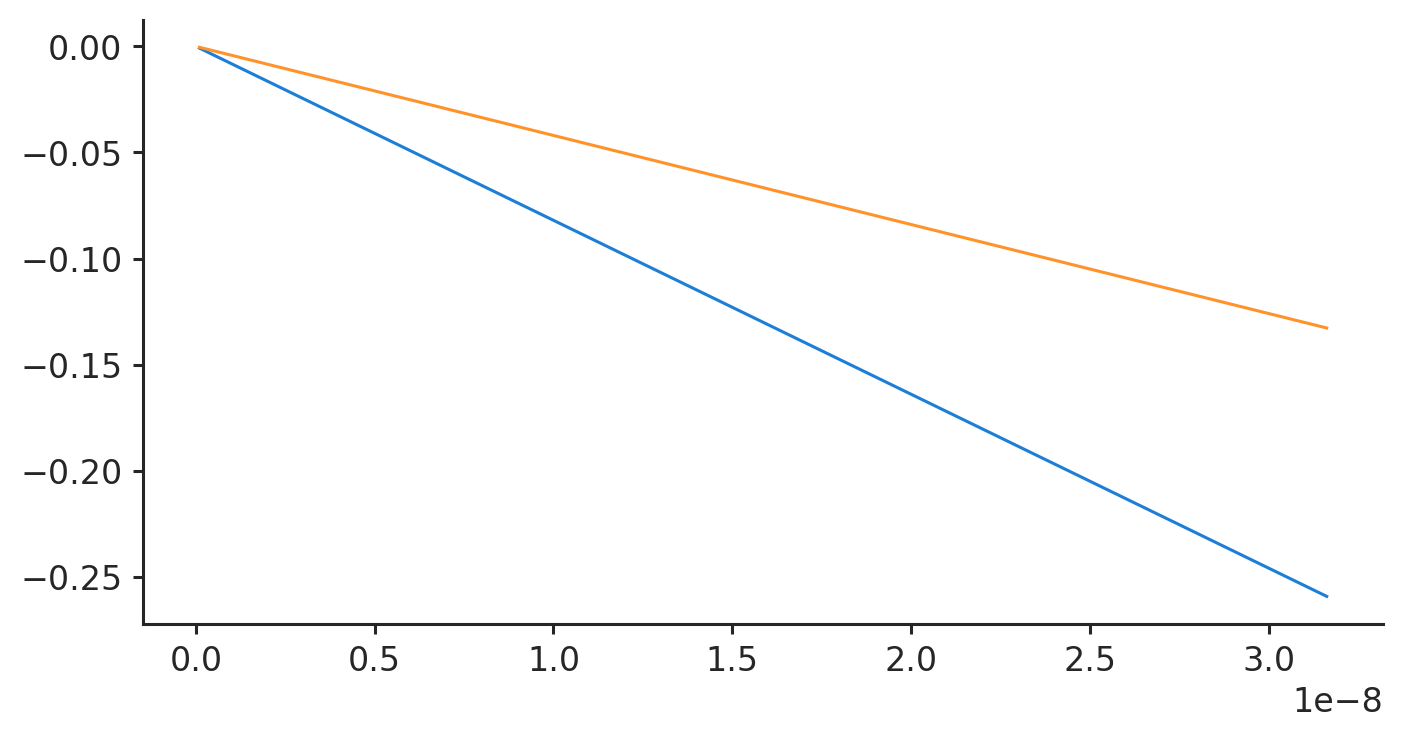

In [177]:
plt.plot(x, b._w_interpolators['chr10'][0][1][0](x))
plt.plot(x, b._w_interpolators['chr10'][0][4][0](x))
#plt.semilogx()

In [98]:
debug

> /home/vsb/projects/bprime/bgspy/utils.py(110)_build_w_interpolators()
    108                     annot_level = []
    109                     interpols[chrom][i][j].append(annot_level)
--> 110                     for k in range(B.shape[3]):
    111                         # annotation class level
    112                         func = interpolate.interp1d(self.w,



ipdb>  B


array([[[-3.1995581e-04],
        [-8.1994274e-04],
        [-1.0619679e-03],
        [-8.1659888e-04],
        [-4.1981143e-04],
        [-2.2623285e-04],
        [-2.0114690e-04]],

       [[-1.0117891e-03],
        [-2.5928866e-03],
        [-3.3582372e-03],
        [-2.5823123e-03],
        [-1.3275603e-03],
        [-7.1541109e-04],
        [-6.3608238e-04]],

       [[-3.1995580e-03],
        [-8.1994273e-03],
        [-1.0619679e-02],
        [-8.1659881e-03],
        [-4.1981144e-03],
        [-2.2623285e-03],
        [-2.0114691e-03]],

       [[-1.0117890e-02],
        [-2.5928866e-02],
        [-3.3582374e-02],
        [-2.5823124e-02],
        [-1.3275603e-02],
        [-7.1541108e-03],
        [-6.3608233e-03]],

       [[-3.1995580e-02],
        [-8.1994273e-02],
        [-1.0619679e-01],
        [-8.1659883e-02],
        [-4.1981142e-02],
        [-2.2623286e-02],
        [-2.0114690e-02]],

       [[-1.0117891e-01],
        [-2.5928867e-01],
        [-3.3582371e-01],
  

ipdb>  B.shape


(6, 7, 1)


ipdb>  exit


In [45]:
ll, grid = loglik(mle_pi0, B, Y)
wi, ti = grid[np.argmax(ll)][0]
m.w[wi], m.t[ti]

(3.162277660168379e-08, 0.021544346900318822)

In [ ]:
grid_ll(ll, grid):
    

In [33]:
grid

[((0, 0),),
 ((0, 1),),
 ((0, 2),),
 ((0, 3),),
 ((0, 4),),
 ((0, 5),),
 ((0, 6),),
 ((1, 0),),
 ((1, 1),),
 ((1, 2),),
 ((1, 3),),
 ((1, 4),),
 ((1, 5),),
 ((1, 6),),
 ((2, 0),),
 ((2, 1),),
 ((2, 2),),
 ((2, 3),),
 ((2, 4),),
 ((2, 5),),
 ((2, 6),),
 ((3, 0),),
 ((3, 1),),
 ((3, 2),),
 ((3, 3),),
 ((3, 4),),
 ((3, 5),),
 ((3, 6),),
 ((4, 0),),
 ((4, 1),),
 ((4, 2),),
 ((4, 3),),
 ((4, 4),),
 ((4, 5),),
 ((4, 6),),
 ((5, 0),),
 ((5, 1),),
 ((5, 2),),
 ((5, 3),),
 ((5, 4),),
 ((5, 5),),
 ((5, 6),)]

In [20]:
def loglik_alt(pi0, B, y):
    # y is nsame, ndiff as cols
    # TODO does pi0 matter?
    assert(np.all(pi0 <= 0.5))
    pi = np.exp(np.add.outer(np.log(pi0), B))
    assert(np.all(pi <= 0.5))
    pi[pi==0] = SMALLEST
    #return y
    a = np.log(pi)*y[None, :, 1, None, None, None]
    b = np.log1p(-pi)*y[None, :, 0, None, None, None]
    assert(np.all(np.isfinite(a) | np.isnan(a)))
    assert(np.all(np.isfinite(b) | np.isnan(b)))
    ll = a + b
    #__import__('pdb').set_trace()
    return ll

loglik_alt(mle_pi0, B, Y)

FloatingPointError: underflow encountered in nextafter

In [21]:
debug

> /tmp/ipykernel_73935/2195709474.py(7)loglik_alt()
      5     pi = np.exp(np.add.outer(np.log(pi0), B))
      6     assert(np.all(pi <= 0.5))
----> 7     pi[pi==0] = np.nextafter(0, 1)
      8     #return y
      9     a = np.log(pi)*y[None, :, 1, None, None, None]



ipdb>  np.nextafter(0, 1)


*** FloatingPointError: underflow encountered in nextafter


ipdb>  pi.dtype


dtype('float64')


ipdb>  np.nextafter(np.float32(0), np.float32(1))


*** FloatingPointError: underflow encountered in nextafter


ipdb>  exit


In [139]:
a, b = loglik(mle_pi0, B, Y)

In [144]:
wi, ti = b[np.argmax(a)][0]
m.w[wi], m.t[ti]

(3.16e-08, 0.000316)

TypeError: Invalid shape (42,) for image data

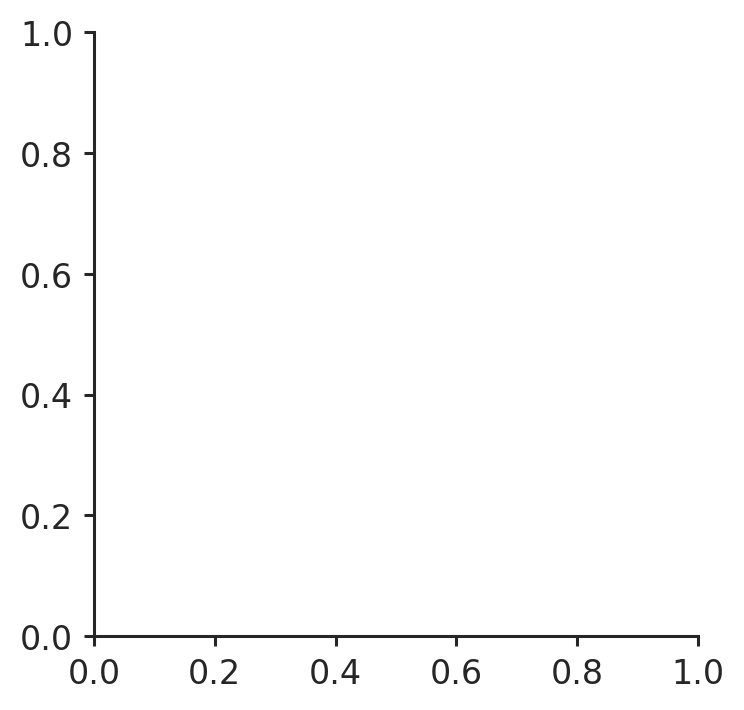

In [145]:
plt.imshow(a)